### FPGA Acelleration for Image Processing: Thresholding

#### Import overlay in instantiate FPGA modules

In [61]:
from pynq import Overlay, Xlnk
import pynq.lib.dma
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

overlay = Overlay('/home/xilinx/pynq/overlays/threshold_overlay/mt.bit')
print(overlay.ip_dict)
dma = overlay.axi_dma_0
sat = overlay.saturation_linkup_0

/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:299: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


{'axi_dma_0': {'phys_addr': 1077936128, 'addr_range': 65536, 'type': 'xilinx.com:ip:axi_dma:7.1', 'state': None, 'interrupts': {}, 'gpio': {}, 'fullpath': 'axi_dma_0', 'mem_id': 'SEG_axi_dma_0_Reg', 'driver': <class 'pynq.lib.dma.DMA'>}, 'saturation_linkup_0': {'phys_addr': 1136656384, 'addr_range': 65536, 'type': 'ucdenver.pvt:user:saturation_linkup:1.0', 'state': None, 'interrupts': {}, 'gpio': {}, 'fullpath': 'saturation_linkup_0', 'mem_id': 'SEG_saturation_linkup_0_S00_AXI_reg', 'driver': <class 'pynq.overlay.DefaultIP'>}}


/usr/local/lib/python3.6/dist-packages/pynq/lib/dma.py:200: UserWarning: Failed to find parameter c_sg_length_width; users should really use *.hwh files for overlays.
  warnings.warn(message, UserWarning)


#### Customize Parameters and Select Image
The second argument of sat.write configures the threshold value. (range 0-255)

In [110]:
#set threshold value (range 0-255)
FPGA_THRESHOLD_VALUE = 150
SOFTWARE_THRESHOLD_VALUE = 128

sat.write(0,FPGA_THRESHOLD_VALUE) 
image_path = '../images/lena_gray.bmp'

#### Process Image using both FPGA fabric and software methods (for comparison)

In [111]:
in_image = cv2.imread(image_path,0)
in_image = in_image.flatten()

xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(in_image.shape[0]), dtype = np.int32)
out_buffer = xlnk.cma_array(shape=(in_image.shape[0]), dtype = np.int32)

#put into fabric
np.copyto(in_buffer, in_image)
start_time = time.time()
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()
stop_time = time.time()
in_buffer.close()
out_buffer.close()

print('{} : FPGA Time'.format(stop_time-start_time))

#do using software
start_time = time.time()
img = cv2.imread(image_path, 0)
ret,cv_threshed = cv2.threshold(img,SOFTWARE_THRESHOLD_VALUE,255,cv2.THRESH_BINARY)
stop_time = time.time()
print('{} : Software Time'.format(stop_time-start_time))


0.005064249038696289 : FPGA Time
0.0177462100982666 : Software Time


#### Display origial and resulting images post FGPA and software processing

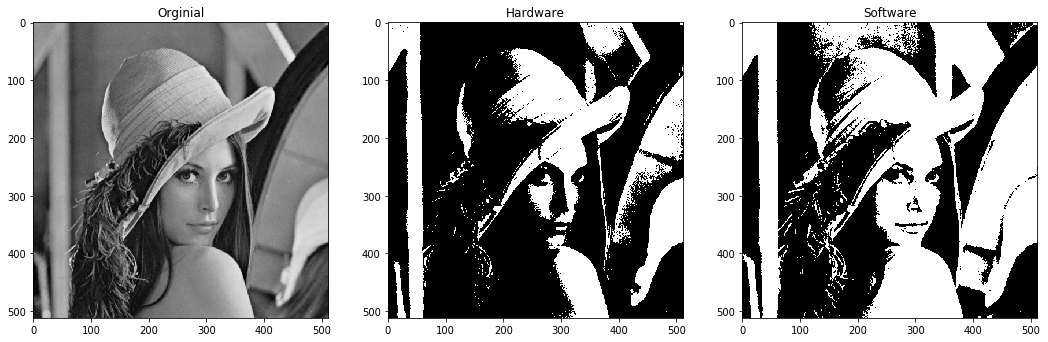

In [112]:
img = cv2.imread(image_path,0)
fig = plt.figure()
fig = plt.figure(figsize=(fig.get_size_inches()*3))
fig.add_subplot(1,3,1)
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.title('Orginial')
fig.add_subplot(1,3,2)
plt.imshow(out_buffer.reshape(img.shape[0],img.shape[1]),cmap=plt.get_cmap('gray'))
plt.title('Hardware')
fig.add_subplot(1,3,3)
plt.imshow(cv_threshed,cmap=plt.get_cmap('gray'))
plt.title('Software')
plt.show()